In [26]:
!pip install pandas numpy matplotlib seaborn nltk scikit-learn yfinance shap transformers torch tqdm


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\shawa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [27]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Explainability
import shap

# Display plots inline
%matplotlib inline


In [28]:
# Load your JSON files
train = pd.read_json("TweetFinSent_Train.json")
test = pd.read_json("TweetFinSent_Test.json")

# Add dataset type
train['dataset_type'] = 'train'
test['dataset_type'] = 'test'

# Combine datasets
df = pd.concat([train, test], ignore_index=True)

# Inspect dataset
df.head()


,Tweet_ID,Target_Ticker,Sentiment,dataset_type
0,1354892404093034496,BBBY,NEUTRAL,train
1,1410235145668399104,TSLA,POSITIVE,train
2,1410663438871838720,AMC,NEGATIVE,train
3,1378203492179841024,TSLA,NEUTRAL,train
4,1402575633327165440,CLOV,POSITIVE,train


C:\Users\shawa\AppData\Local\Temp\ipykernel_9748\780059368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sentiment', palette='Set2')


Index(['Tweet_ID', 'Target_Ticker', 'Sentiment', 'dataset_type'], dtype='object')


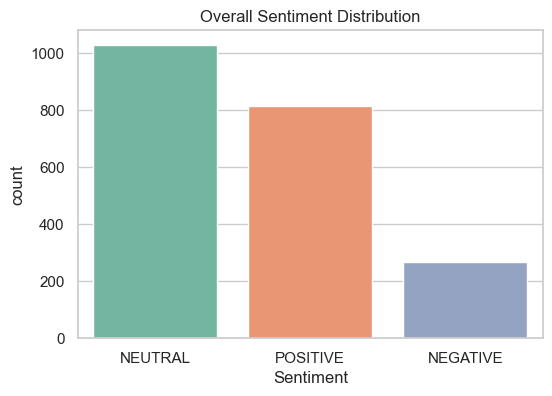

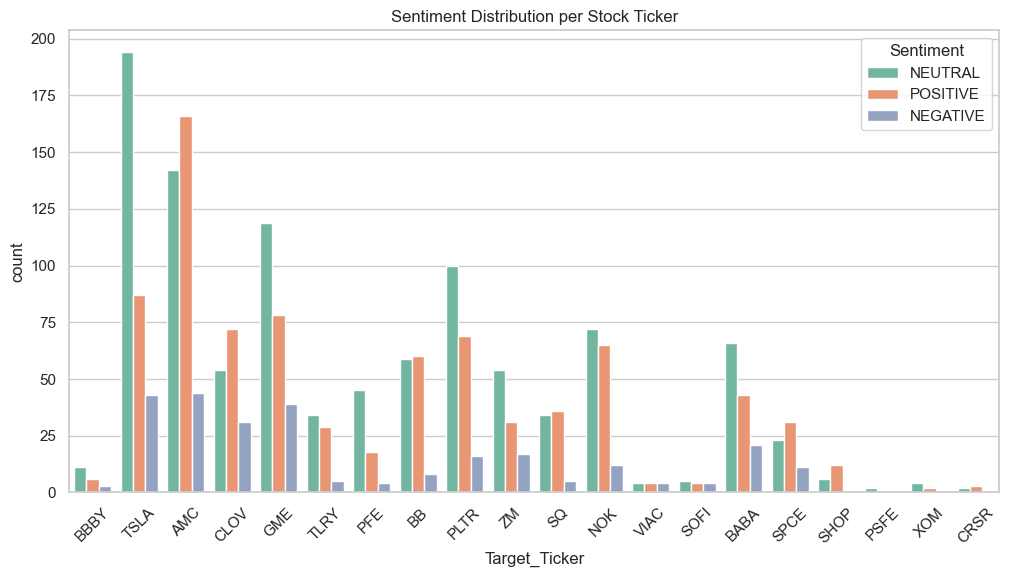

In [29]:
# Check column names
print(df.columns)

# Sentiment distribution overall
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sentiment', palette='Set2')
plt.title("Overall Sentiment Distribution")
plt.show()

# Sentiment per stock ticker
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='Target_Ticker', hue='Sentiment', palette='Set2')
plt.title("Sentiment Distribution per Stock Ticker")
plt.xticks(rotation=45)
plt.show()


In [30]:
# Encode Sentiment
le_sent = LabelEncoder()
df['Sentiment_encoded'] = le_sent.fit_transform(df['Sentiment'])

# Encode Stock Ticker
le_ticker = LabelEncoder()
df['Ticker_encoded'] = le_ticker.fit_transform(df['Target_Ticker'])

# Aggregate sentiment per stock
trend_df = df.groupby(['Target_Ticker', 'Sentiment']).size().unstack(fill_value=0)
trend_df['Total'] = trend_df.sum(axis=1)
trend_df['Positive_pct'] = trend_df.get('POSITIVE', 0) / trend_df['Total'] * 100
trend_df['Neutral_pct'] = trend_df.get('NEUTRAL', 0) / trend_df['Total'] * 100
trend_df['Negative_pct'] = trend_df.get('NEGATIVE', 0) / trend_df['Total'] * 100

trend_df.reset_index(inplace=True)
trend_df


Sentiment,Target_Ticker,NEGATIVE,NEUTRAL,POSITIVE,Total,Positive_pct,Neutral_pct,Negative_pct
0,AMC,44,142,166,352,47.159091,40.340909,12.500000
1,BABA,21,66,43,130,33.076923,50.769231,16.153846
2,BB,8,59,60,127,47.244094,46.456693,6.299213
3,BBBY,3,11,6,20,30.000000,55.000000,15.000000
4,CLOV,31,54,72,157,45.859873,34.394904,19.745223
5,CRSR,0,2,3,5,60.000000,40.000000,0.000000
6,GME,39,119,78,236,33.050847,50.423729,16.525424
7,NOK,12,72,65,149,43.624161,48.322148,8.053691
8,PFE,4,45,18,67,26.865672,67.164179,5.970149
9,PLTR,16,100,69,185,37.297297,54.054054,8.648649


<Figure size 1200x600 with 0 Axes>

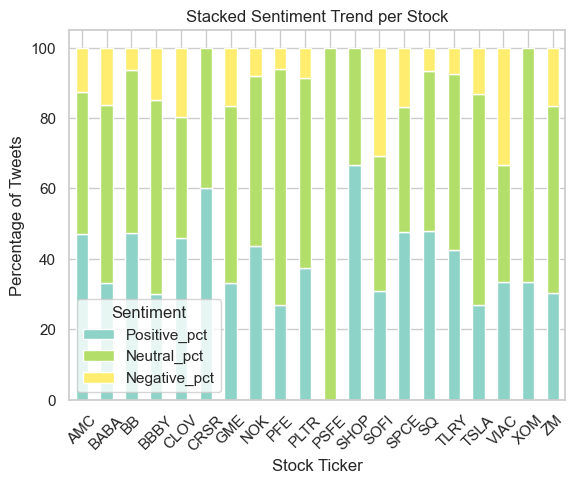

In [31]:
plt.figure(figsize=(12,6))
trend_df.set_index('Target_Ticker')[['Positive_pct','Neutral_pct','Negative_pct']].plot(kind='bar', stacked=True, colormap='Set3')
plt.title("Stacked Sentiment Trend per Stock")
plt.ylabel("Percentage of Tweets")
plt.xlabel("Stock Ticker")
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.show()


In [32]:
# Features & labels
X = df[['Ticker_encoded']]  # Stock as input
y = df['Sentiment_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred, target_names=le_sent.classes_))


              precision    recall  f1-score   support

    NEGATIVE       0.00      0.00      0.00        47
     NEUTRAL       0.54      0.63      0.58       212
    POSITIVE       0.46      0.49      0.48       164

    accuracy                           0.51       423
   macro avg       0.33      0.37      0.35       423
weighted avg       0.45      0.51      0.48       423



C:\Users\shawa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\shawa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\shawa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_clas

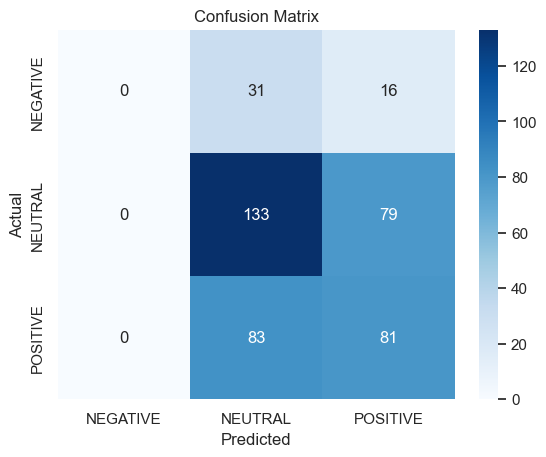

In [34]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_sent.classes_, yticklabels=le_sent.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


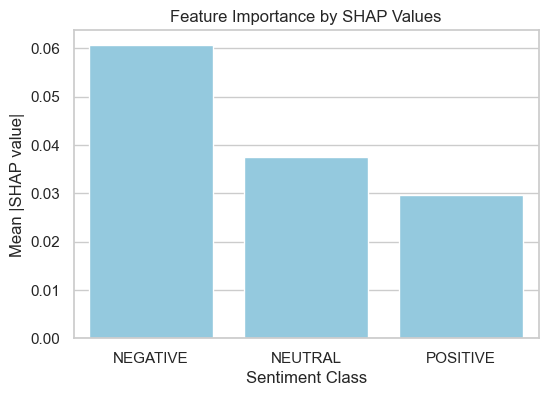

In [38]:
plt.figure(figsize=(6,4))
sns.barplot(data=importance_df, x='Sentiment', y='Mean_SHAP', color='skyblue')
plt.title("Feature Importance by SHAP Values")
plt.ylabel("Mean |SHAP value|")
plt.xlabel("Sentiment Class")
plt.show()


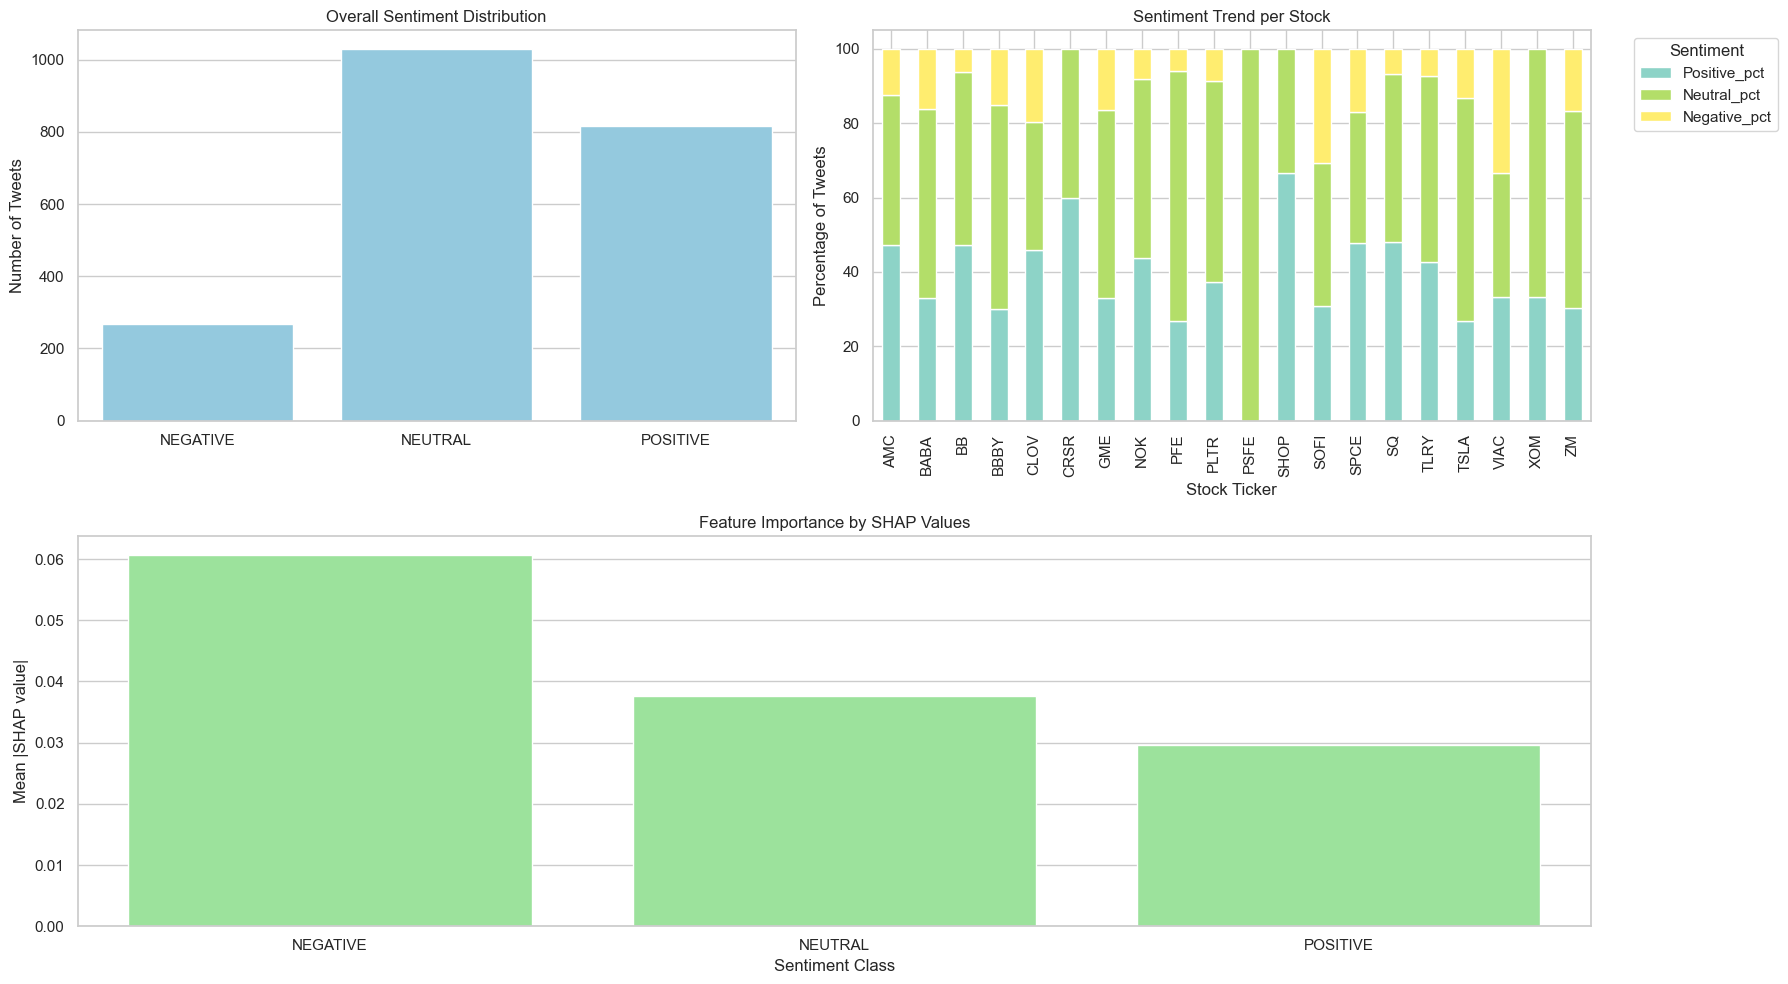

In [39]:
import matplotlib.gridspec as gridspec

# Set style
sns.set_style("whitegrid")

# Create figure and subplots
plt.figure(figsize=(18,10))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1,1])

# ------------------------------
# Plot 1: Overall Sentiment Distribution
# ------------------------------
ax0 = plt.subplot(gs[0,0])
sns.countplot(data=df, x='Sentiment', order=le_sent.classes_, color='skyblue', ax=ax0)
ax0.set_title("Overall Sentiment Distribution")
ax0.set_xlabel("")
ax0.set_ylabel("Number of Tweets")

# ------------------------------
# Plot 2: Sentiment per Stock (Stacked %)
# ------------------------------
ax1 = plt.subplot(gs[0,1])
trend_df.set_index('Target_Ticker')[['Positive_pct','Neutral_pct','Negative_pct']].plot(
    kind='bar', stacked=True, colormap='Set3', ax=ax1)
ax1.set_title("Sentiment Trend per Stock")
ax1.set_ylabel("Percentage of Tweets")
ax1.set_xlabel("Stock Ticker")
ax1.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

# ------------------------------
# Plot 3: SHAP Feature Importance
# ------------------------------
ax2 = plt.subplot(gs[1,:])
sns.barplot(data=importance_df, x='Sentiment', y='Mean_SHAP', color='lightgreen', ax=ax2)
ax2.set_title("Feature Importance by SHAP Values")
ax2.set_ylabel("Mean |SHAP value|")
ax2.set_xlabel("Sentiment Class")

# ------------------------------
# Adjust layout
# ------------------------------
plt.tight_layout()
plt.show()


In [40]:
print("=== Social Media Trend Analysis Insights ===\n")

# 1. Overall Sentiment
sentiment_counts = df['Sentiment'].value_counts()
print(f"1️⃣ Overall Sentiment Distribution:")
for s in le_sent.classes_:
    print(f"   {s}: {sentiment_counts.get(s, 0)} tweets")

# 2. Top Positive and Negative Stocks
top_positive = trend_df.sort_values(by='Positive_pct', ascending=False).iloc[0]
top_negative = trend_df.sort_values(by='Negative_pct', ascending=False).iloc[0]
print("\n2️⃣ Top Stocks by Sentiment Percentage:")
print(f"   Most Positive: {top_positive['Target_Ticker']} ({top_positive['Positive_pct']:.2f}%)")
print(f"   Most Negative: {top_negative['Target_Ticker']} ({top_negative['Negative_pct']:.2f}%)")

# 3. Stocks with Balanced Sentiment (Neutral Dominant)
neutral_dominant = trend_df.sort_values(by='Neutral_pct', ascending=False).iloc[0]
print(f"   Most Neutral: {neutral_dominant['Target_Ticker']} ({neutral_dominant['Neutral_pct']:.2f}%)")

# 4. Feature Influence (SHAP Insights)
most_influential = importance_df.sort_values(by='Mean_SHAP', ascending=False).iloc[0]
print(f"\n3️⃣ Feature Importance Insight (from SHAP):")
print(f"   Feature '{most_influential['Sentiment']}' has highest influence on sentiment prediction.")


=== Social Media Trend Analysis Insights ===

1️⃣ Overall Sentiment Distribution:
   NEGATIVE: 267 tweets
   NEUTRAL: 1030 tweets
   POSITIVE: 816 tweets

2️⃣ Top Stocks by Sentiment Percentage:
   Most Positive: SHOP (66.67%)
   Most Negative: VIAC (33.33%)
   Most Neutral: PSFE (100.00%)

3️⃣ Feature Importance Insight (from SHAP):
   Feature 'NEGATIVE' has highest influence on sentiment prediction.
